In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [2]:
class RatingPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, bin_edges = [1, 3, 6, 9, 12], max_rating = 5):
        self.max_rating = max_rating
        self.bin_edges = bin_edges

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
                
        print("Changing to Rating Model")

        bin_edges = self.bin_edges + [float('inf')]
        bin_labels = [rating for rating in range(self.max_rating, 0, -1)]

        for col in X.columns:
            X[col] = pd.cut(X[col], bins=bin_edges, labels=bin_labels, right=True)
            X[col] = X[col].cat.add_categories([0]).fillna(0)
            X[col] = X[col].astype(int)
        
        return X
    

In [3]:
class NetFlixFormatPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
                
        print("Changing to Netflix Format Model")

        sparse_matrix = sparse.csr_matrix(X)

        # Convert the sparse matrix to a DataFrame
        rows, cols = sparse_matrix.nonzero()

        values = [sparse_matrix[row, col] for row, col in zip(rows, cols)]

        X = pd.DataFrame({'userId': rows, 'movieId': cols, 'rating': values})
            
        return X

In [4]:
class AvgPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, sparse=False):
        self.sparse = sparse

    # get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
    def __get_average_ratings(self, sparse_matrix, of_users):
    
        # average ratings of user/axes
        ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

        # ".A1" is for converting Column_Matrix to 1-D numpy array 
        sum_of_ratings = sparse_matrix.sum(axis=ax).A1
        # Boolean matrix of ratings ( whether a user rated that movie or not)
        is_rated = sparse_matrix!=0
        # no of ratings that each user OR movie..
        no_of_ratings = is_rated.sum(axis=ax).A1
        
        # max_user  and max_movie ids in sparse matrix 
        u,m = sparse_matrix.shape
        # creae a dictonary of users and their average ratigns..
        average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                    for i in range(u if of_users else m) 
                                        if no_of_ratings[i] !=0}

        # return that dictionary of average ratings
        return average_ratings

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        if(not self.sparse):
            X_sparse_matrix = sparse.csr_matrix((X.rating.values, (X.userId.values, X.movieId.values)))
        else:
            X_sparse_matrix = X

        X_avg = dict()

        print("Getting Averages of the model")

        # get the global average of ratings in our X set.
        X_global_average = X_sparse_matrix.sum()/X_sparse_matrix.count_nonzero()
        X_avg['global'] = X_global_average

        X_avg['user'] = self.__get_average_ratings(X_sparse_matrix, of_users=True)
        X_avg['movie'] =  self.__get_average_ratings(X_sparse_matrix, of_users=False)
        
        return {"sparse":X_sparse_matrix, "avg":X_avg}

In [5]:
class SimilarityPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, similar_movies = True, similar_users = True):
        self.similar_movies = similar_movies
        self.similar_users = similar_users
    
    def __calculate_similarity_by_user(self, X, user, movie):
         #--------------------- Ratings of "movie" by similar users of "user" ---------------------       
        user_sim = cosine_similarity(X["sparse"][user], X["sparse"]).ravel()
        top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
        # get the ratings of most similar users for this movie
        top_ratings = X["sparse"][top_sim_users, movie].toarray().ravel()
        # we will make it's length "5" by adding movie averages to .
        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_users_ratings.extend([X["avg"]['movie'][movie]]*(5 - len(top_sim_users_ratings)))

        return top_sim_users_ratings

    def __calculate_similarity_by_movie(self, X, user, movie):
        #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
        # compute the similar movies of the "movie"        
        movie_sim = cosine_similarity(X["sparse"][:,movie].T, X["sparse"].T).ravel()
        top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
        # get the ratings of most similar movie rated by this user..
        top_ratings = X["sparse"][user, top_sim_movies].toarray().ravel()
        # we will make it's length "5" by adding user averages to.
        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_movies_ratings.extend([X["avg"]['user'][user]]*(5-len(top_sim_movies_ratings))) 

        return top_sim_movies_ratings
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):

        print("Getting Similarity of the model")
        final_data = pd.DataFrame()
        count = 0
        # get users, movies and ratings from our samples train sparse matrix
        train_users, train_movies, train_ratings = sparse.find(X["sparse"])

        for (user, movie, rating) in zip(train_users, train_movies, train_ratings):
            
            st = datetime.now()
            
            top_sim_users_ratings = self.__calculate_similarity_by_user(X, user, movie)
            top_sim_movies_ratings = self.__calculate_similarity_by_movie(X, user, movie)
            
            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(X["avg"]['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(X["avg"]['user'][user])
            # Avg_movie rating
            row.append(X["avg"]['movie'][movie])

            row.append(rating)
            count = count + 1
            final_data = pd.concat([final_data, pd.DataFrame([row])], ignore_index=True)
        return final_data.drop([0,1,15], axis=1)


In [6]:
import pandas as pd

df = pd.read_csv("../DATA/user_problem.csv", index_col=0)
df

,36,37,38,39,40,41,42,43,44,45,...,5218,5219,5220,5221,5222,5223,5224,5225,5226,5227
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,5,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,-2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71967,6,3,2,-7,-2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71968,17,4,20,6,9,22,8,4,10,2,...,0,0,0,0,0,0,0,0,0,0
71969,4,0,0,5,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
71970,-3,0,1,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
samples = df.sample(n=1000).copy()

In [8]:
df_format = make_pipeline(RatingPreprocessor(), NetFlixFormatPreprocessor()).fit_transform(samples)
df_format

X = df_format
y = df_format["rating"]

Changing to Rating Model
Changing to Netflix Format Model


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
rmse = make_scorer(mean_squared_error, squared=False)
mape = make_scorer(mean_absolute_percentage_error)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# List of models to compare
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(random_state=0)),
    ("SVM Regressor", SVR(kernel="linear")),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=0)),
    ("XGBoost", XGBRegressor(silent=False, n_jobs=13, random_state=0, n_estimators=100)),
    ("Dummy", DummyRegressor(strategy="mean"))
]

In [12]:
method_scores = {}
for model in models:
    print("[{}]".format(model))
    method_scores[model[0]] = cross_validate(make_pipeline(AvgPreprocessor(), SimilarityPreprocessor(), model[1]), X, y, cv=5, scoring={"RMSE":rmse, "MAPE":mape})

[('Linear Regression', LinearRegression())]
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
[('Random Forest', RandomForestRegressor(random_state=0))]
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model
Getting Similarity of the model
Getting Averages of the model

In [16]:
method_scores

{'Linear Regression': {'fit_time': array([3.74249673, 3.58270741, 3.57978964, 3.57682681, 3.58941174]),
  'score_time': array([0.83985662, 0.85387564, 0.81213474, 0.8383286 , 0.83147073]),
  'test_RMSE': array([1.14946079, 1.01554483, 1.06984058, 1.11277665, 1.33257818]),
  'test_MAPE': array([0.37997949, 0.28097198, 0.32017218, 0.3513265 , 0.5145215 ])},
 'Random Forest': {'fit_time': array([3.79479027, 3.77992225, 3.76818871, 3.75925565, 3.74361181]),
  'score_time': array([0.84270978, 0.85539055, 0.81721497, 0.85908699, 0.83326411]),
  'test_RMSE': array([1.23652461, 1.01951461, 1.08696387, 1.1905228 , 1.4124728 ]),
  'test_MAPE': array([0.39375519, 0.28050303, 0.32709885, 0.36729664, 0.5314942 ])},
 'SVM Regressor': {'fit_time': array([3.69196963, 3.64601302, 3.64147711, 3.63326311, 3.65481186]),
  'score_time': array([0.83210802, 0.84621   , 0.81272125, 0.85363984, 0.83107138]),
  'test_RMSE': array([1.41006594, 1.00697569, 1.25544127, 1.23779204, 1.61380427]),
  'test_MAPE': arra

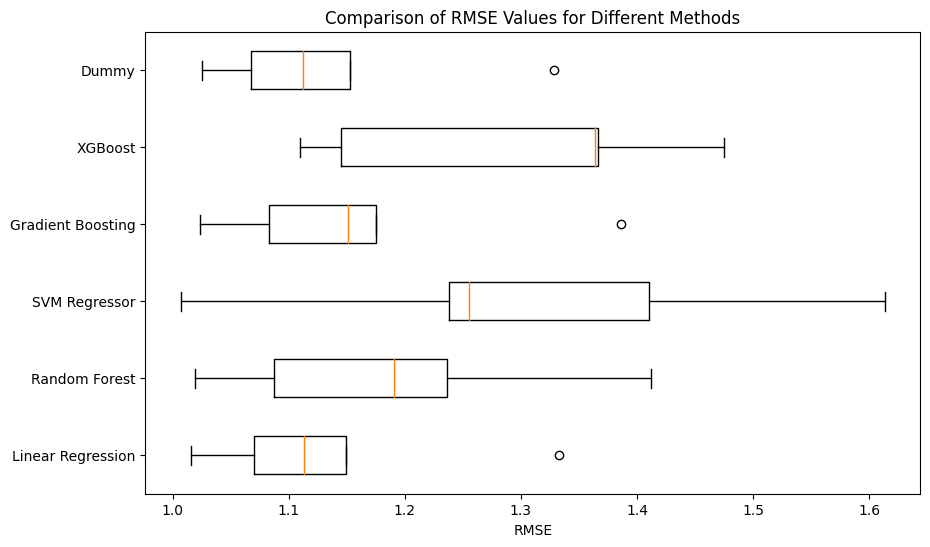

In [18]:
import matplotlib.pyplot as plt

# Sample RMSE values for different methods
rmse_values = {model:method_scores[model]['test_RMSE'] for model in method_scores}

# Create a list of method names for labeling
methods = list(rmse_values.keys())

# Create a list of RMSE values for plotting
data = list(rmse_values.values())

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=methods, vert=False)
plt.title("Comparison of RMSE Values for Different Methods")
plt.xlabel("RMSE")
plt.show()

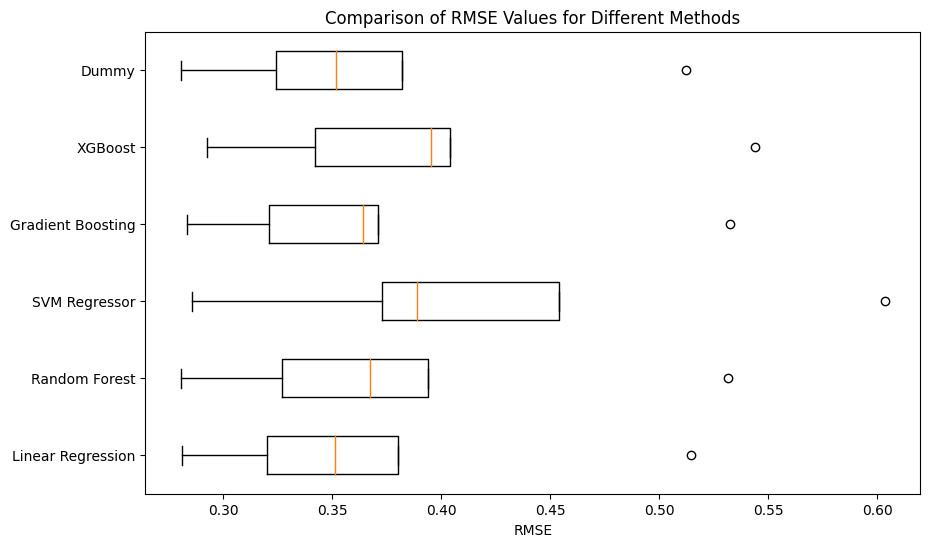

In [19]:
import matplotlib.pyplot as plt

# Sample RMSE values for different methods
rmse_values = {model:method_scores[model]['test_MAPE'] for model in method_scores}

# Create a list of method names for labeling
methods = list(rmse_values.keys())

# Create a list of RMSE values for plotting
data = list(rmse_values.values())

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=methods, vert=False)
plt.title("Comparison of RMSE Values for Different Methods")
plt.xlabel("RMSE")
plt.show()